# Importing and Loading Data

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_data = pd.read_csv(r'C:\Users\Xu Chenyu\Desktop\Project\prudential-life-insurance-assessment\train.csv')
test_data = pd.read_csv(r'C:\Users\Xu Chenyu\Desktop\Project\prudential-life-insurance-assessment\test.csv')
all_data = train_data.append(test_data,sort=True)

In [2]:
all_data.head()

,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,Family_Hist_1,Family_Hist_2,Family_Hist_3,...,Medical_Keyword_9,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Response,Wt
0,0.323008,0.028,12,1,0.0,3,NaN,2,NaN,0.598039,...,0,1,D3,10,0.076923,2,1,1,8.0,0.148536
1,0.272288,0.000,1,3,0.0,2,0.0018,2,0.188406,NaN,...,0,1,A1,26,0.076923,2,3,1,4.0,0.131799
2,0.428780,0.030,9,1,0.0,2,0.0300,3,0.304348,NaN,...,0,1,E1,26,0.076923,2,3,1,8.0,0.288703
3,0.352438,0.042,9,1,0.0,3,0.2000,3,0.420290,NaN,...,0,1,D4,10,0.487179,2,3,1,8.0,0.205021
4,0.424046,0.027,9,1,0.0,2,0.0500,2,0.463768,NaN,...,0,1,D2,26,0.230769,2,3,1,8.0,0.234310


# Data preprocessing

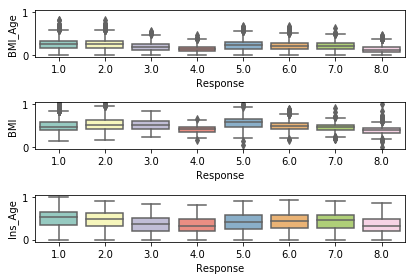

In [3]:
# BMI, Ins_Age

all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']
# plt.scatter(all_data['Response'], all_data['BMI_Age'])
fig,axes = plt.subplots(3,1,sharey=True)
sns.boxplot(x = "Response", y = "BMI_Age", data = all_data, palette = "Set3", ax=axes[0])
sns.boxplot(x = "Response", y = "BMI", data = all_data, palette = "Set3",ax=axes[1])
sns.boxplot(x = "Response", y = "Ins_Age", data = all_data, palette = "Set3",ax=axes[2])
fig.tight_layout()

In [4]:
# Medical_Keywords

med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Medical_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

In [5]:
# 将字符串型变量Product_Info_2进行拆分

all_data['Product_Info_2_char'] = all_data.Product_Info_2.str[0]
all_data['Product_Info_2_num'] = all_data.Product_Info_2.str[1]

all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

## Missing values

### Deletion

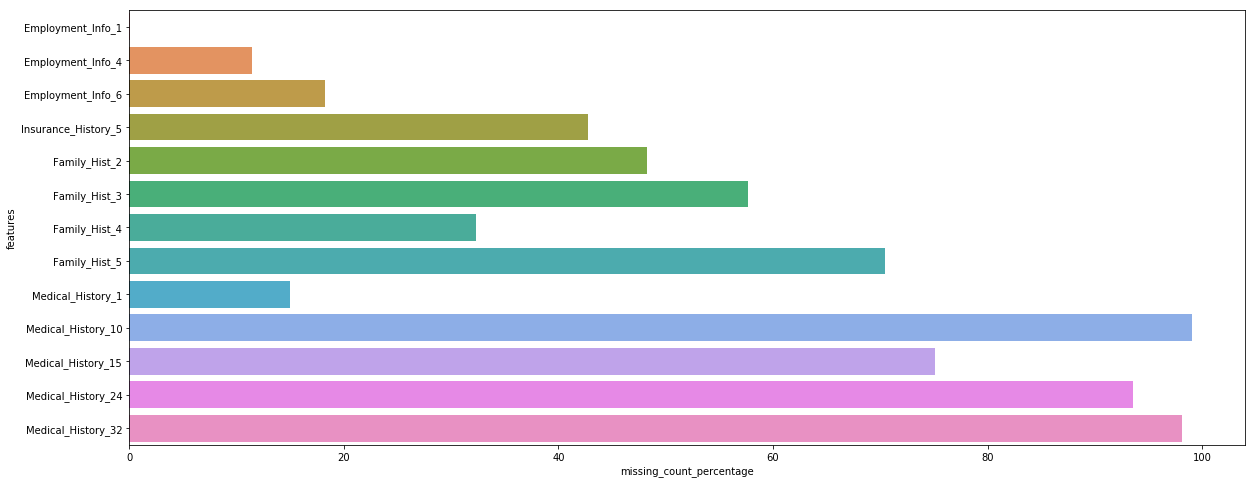

In [6]:
# 可视化缺失值占比

missing = train_data.isnull().sum()[train_data.isnull().sum() != 0]
missing = pd.DataFrame(missing.reset_index())
missing.rename(columns = {'index': 'features', 0: 'missing_count'}, inplace = True)
missing['missing_count_percentage'] = ((missing['missing_count']) / 59381) * 100 # 59381 -- row number
plt.figure(figsize = (20, 8))
g = sns.barplot(x = missing['missing_count_percentage'], y = missing['features'], data = missing)

In [7]:
from sklearn import preprocessing

# 丢弃缺失值过多的特征
columns_to_drop = ['Id', 'Medical_History_32', 'Medical_History_24', 'Medical_History_15', 'Medical_History_10','Family_Hist_5']

all_data.drop(columns_to_drop, axis = 1, inplace = True)

### Imputation

In [8]:
missing_indicator = -1000 
all_data.fillna(missing_indicator, inplace=True)


## Scaling

### Scaling features to range -- MinMaxScaler

In [9]:
# sns.boxplot(train_data['Medical_History_2'])

In [10]:
#sns.boxplot(all_data['Medical_Keywords_Count'])

In [11]:
def min_max_scaler(x):
    all_data[x] = (all_data[x] - all_data[x].min())/(all_data[x].max() - all_data[x].min())

In [12]:
min_max_scaler('Medical_History_2')
min_max_scaler('Medical_Keywords_Count')

### Scaling data with outliers -- RobustScaler

In [13]:
#sns.boxplot(train_data['Medical_History_1'])

In [14]:
from sklearn.preprocessing import RobustScaler

tmp = np.array(all_data['Medical_History_1'])
tmp_robust = RobustScaler().fit_transform(tmp.reshape(-1, 1))
tmp_robust = pd.DataFrame(tmp_robust)
all_data['Medical_History_1'] = tmp_robust

## Encoding categorical features

### Label Encoder

In [15]:
# 转换target feature的数据类型

all_data['Response'] = preprocessing.LabelEncoder().fit_transform(all_data['Response'])

### One-Hot

## Feature selection

In [16]:
#分离原始 test/train

train = all_data[all_data['Response'] > 0].copy()
test = all_data[all_data['Response'] < 1].copy()

### Random Forest feature selection

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = train['Response']
x = train.drop(['Response'], axis = 1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
forest = RandomForestClassifier(n_estimators=1, random_state=0, n_jobs=1)
forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = x_train.columns[0:]
# for f in range(x_train.shape[1]):
#    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

In [20]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1] # 降序排列

In [21]:
# 选取前118个重要的特征（%95）

x_selected = x_train.iloc[:, indices[0: 118]]
print(x_selected.shape)
print(y_train.shape)

(41566, 118)
(41566,)


### PCA dimension reduction

# Learning
Grid Search

In [22]:
xgb_num_rounds = 900
num_classes = 8

In [23]:
from ml_metrics import quadratic_weighted_kappa
from scipy.optimize import fmin_powell
import xgboost as xgb

def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.03
    params["min_child_weight"] = 200
    params["subsample"] = 0.90
    params["colsample_bytree"] = 0.3
    params["silent"] = 1
    params["max_depth"] = 7
    #params["num_class"] = 8
    plst = list(params.items())
    return plst

def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return quadratic_weighted_kappa(yhat, y)

def score_offset(data, bin_offset, sv, scorer=eval_wrapper):
    # data has the format of pred=0, offset_pred=1, labels=2 in the first dim
    data[1, data[0].astype(int)==sv] = data[0, data[0].astype(int)==sv] + bin_offset
    score = scorer(data[1], data[2])
    return score
    
def apply_offsets(data, offsets):
    for j in range(num_classes):
        data[1, data[0].astype(int)==j] = data[0, data[0].astype(int)==j] + offsets[j]
    return data

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#小写
x_train = x_selected

#划分过的大写
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state = 1)

data_train = xgb.DMatrix(X_train, Y_train.values)
data_test = xgb.DMatrix(X_test, label = Y_test)

C:\Users\Xu Chenyu\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [25]:
# 参数设置
plst = get_params()
print(plst)

# 训练模型
clf = xgb.train(plst, data_train, xgb_num_rounds)

# 预测模型
Y_pred_train = clf.predict(data_train)
print('Train score is:', eval_wrapper(Y_pred_train, Y_train)) 

Y_pred = clf.predict(data_test)
print('Test score is:', eval_wrapper(Y_pred, Y_test)) 

[('max_depth', 7), ('objective', 'reg:linear'), ('min_child_weight', 200), ('colsample_bytree', 0.3), ('eta', 0.03), ('silent', 1), ('subsample', 0.9)]
Train score is: 0.6323363932637966
Test score is: 0.563341178447164


In [26]:
# train offsets 
offsets = np.array([-0.5, -0.5, -1.3, -1.3, -1, 1, 0, 0])
offset_preds = np.vstack((Y_pred, Y_pred, Y_test.values))
offset_preds = apply_offsets(offset_preds, offsets)
opt_order = [7,6,4,5,3,2,1,0]
for j in opt_order:
    train_offset = lambda x: -score_offset(offset_preds, x, j)
    offsets[j] = fmin_powell(train_offset, offsets[j], disp=False)

print('Offset Train score is:', eval_wrapper(offset_preds[1], Y_test)) 

Offset Train score is: 0.6189773776130341


In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, offset_preds[1]))

ValueError: Found input variables with inconsistent numbers of samples: [17815, 10392]

#  Evaluation
Classification Report

# Prediction